# Validation
## Geometry and basic setup

In [14]:
import sympy as sp
import numpy as np
import polyscope as ps
import pymem3dg as dg
import math
import matplotlib.pyplot as plt

# a = sp.symbols('a')
# c = sp.symbols('c')
# e = sp.sqrt(1- c**2/a**2)
a = 1
c = 0.5
e = np.sqrt(1 - c**2/a**2)
sp.init_printing(use_unicode=True)

parameters = dg.Parameters()
parameters.bending.Kbc = 1
parameters.tension.isConstantSurfaceTension = True
parameters.tension.Ksg = 1
parameters.osmotic.isConstantOsmoticPressure = True
parameters.osmotic.Kv = 1


def polyVisualize():
    ps.init()
    ps_mesh = ps.register_surface_mesh("RBC", coord, topo)
    # ps_mesh.add_scalar_quantity("mean_curvature_diff", abs(H_num - H) )
    # ps_mesh.add_scalar_quantity("gauss_curvature_diff", abs(K_num - K) )
    # ps_mesh.add_scalar_quantity("mean_curvature_num", H_num )
    # ps_mesh.add_scalar_quantity("gauss_curvature_num", K_num )
    # ps_mesh.add_scalar_quantity("mean_curvature", H)
    # ps_mesh.add_scalar_quantity("gauss_curvature",  K)

    # ps_mesh.add_vector_quantity(
    #     "mean_curvature_diff", (H_num - H))
    # ps_mesh.add_vector_quantity(
    #     "gauss_curvature_diff", (K_num - K))
    # ps_mesh.add_scalar_quantity(
    #     "mean_curvature_diff", rowwiseNorm(H_num - H))
    # ps_mesh.add_scalar_quantity(
    #     "gauss_curvature_diff", rowwiseNorm(K_num - K))
    # ps_mesh.add_vector_quantity("mean_curvature_num", H_num)
    # ps_mesh.add_vector_quantity("gauss_curvature_num", K_num)
    # ps_mesh.add_vector_quantity("mean_curvature", H)
    # ps_mesh.add_vector_quantity("gauss_curvature",  K)

    ps_mesh.add_scalar_quantity("geocentric beta",
                                parametricToGeocentricLatitude_pt(parametricBeta))

    ps_mesh.add_scalar_quantity("laplacianH_diff",
                                rowwiseNorm(laplacianH_num - laplacianH)/ rowwiseNorm(laplacianH))
    ps_mesh.add_scalar_quantity("laplacianH_cotan_diff",
                                rowwiseNorm(laplacianH - laplacianH_cotan)/rowwiseNorm(laplacianH))
    ps_mesh.add_scalar_quantity(
        "laplacianH", rowwiseNorm(laplacianH))
    vmin = np.min(rowwiseNorm(laplacianH))
    vmax = np.max(rowwiseNorm(laplacianH))
    ps_mesh.add_scalar_quantity(
        "laplacianH_num", rowwiseNorm(laplacianH_num),  vminmax=(vmin, vmax))
    ps_mesh.add_scalar_quantity(
        "laplacianH_cotan", rowwiseNorm(laplacianH_cotan), vminmax=(vmin, vmax))
    # ps_mesh.add_vector_quantity(
    #     "laplacianH_num", laplacianH_num)
    # ps_mesh.add_vector_quantity(
    #     "laplacianH", laplacianH)
    # ps_mesh.add_vector_quantity(
    #     "laplacianH_cotan", laplacianH_cotan)

    # ps_mesh.add_scalar_quantity("S_diff",
    #                             rowwiseNorm(S_num - S))
    # ps_mesh.add_vector_quantity(
    #     "S", S_num)
    # ps_mesh.add_vector_quantity(
    #     "S_exact", S)

    ps.set_up_dir("z_up")
    ps.show()


map to mem3dg

In [7]:
def deform(coord):
    x = coord[:, 0]
    y = coord[:, 1]
    z = coord[:, 2]
    theta = np.arctan2(y, x)
    r = (x**2 + y**2)**0.5
    # not a correct definition!!, but simply assign a parametric beta to the mesh
    parametricBeta = np.arctan(z/r)
    coord[:, 0] = a * np.cos(parametricBeta) * np.cos(theta)
    coord[:, 1] = a * np.cos(parametricBeta) * np.sin(theta)
    coord[:, 2] = c * np.sin(parametricBeta)
    # geocentricBeta = np.arctan(coord[:, 2]/ (coord[:, 0]**2 + coord[:, 1]**2)**0.5)
    return coord, theta, parametricBeta


topo, coord = dg.getIcosphere(1, 3)
coord, theta, parametricBeta = deform(coord)

<ipython-input-7-2ba98ded790c>:8: RuntimeWarning: divide by zero encountered in true_divide
  parametricBeta = np.arctan(z/r)


Analytical solution of point-wise value

In [ ]:
def geocentricToParametricLatitude_sym(geocentricBeta):
    return sp.atan(sp.tan(geocentricBeta) / sp.sqrt(1-e**2))


def parametricToGeocentricLatitude_sym(parametricBeta):
    return sp.atan(sp.tan(parametricBeta) * sp.sqrt(1-e**2))


def geocentricToParametricLatitude_pt(geocentricBeta):
    return np.arctan(np.tan(geocentricBeta) / np.sqrt(1-e**2))


def parametricToGeocentricLatitude_pt(parametricBeta):
    return np.arctan(np.tan(parametricBeta) * np.sqrt(1-e**2))


def meanCurvature_sym(parametricBeta):
    meanCurvature = c * ((2 * a**2 + (c**2 - a**2) * sp.cos(parametricBeta)**2)) / \
        (2 * a * (a**2 + (c**2 - a**2) * sp.cos(parametricBeta)**2)**(1.5))
    return meanCurvature


def gaussianCurvature_sym(parametricBeta):
    gaussCurvature = c**2 / (a**2 + (c**2 - a**2) *
                             sp.cos(parametricBeta)**2)**2
    return gaussCurvature


def meanCurvature_pt(parametricBeta):
    meanCurvature = np.zeros(np.shape(parametricBeta)[0])
    betaSympyVariable = sp.symbols('betaSympyVariable')
    scalar = meanCurvature_sym(betaSympyVariable)
    for i in range(len(parametricBeta)):
        parametricBeta_i = parametricBeta[i]
        meanCurvature[i] = scalar.subs(
            betaSympyVariable, parametricBeta_i)
    return meanCurvature


def gaussianCurvature_pt(parametricBeta):
    gaussianCurvature = np.zeros(np.shape(parametricBeta)[0])
    betaSympyVariable = sp.symbols('betaSympyVariable')
    scalar = gaussianCurvature_sym(betaSympyVariable)
    for i in range(len(parametricBeta)):
        parametricBeta_i = parametricBeta[i]
        gaussianCurvature[i] = scalar.subs(
            betaSympyVariable, parametricBeta_i)
    return gaussianCurvature


def meanCurvatureVec_pt(geocentricBeta, theta):
    meanCurvature = np.zeros([np.shape(parametricBeta)[0], 3])
    betaSympyVariable = sp.symbols('betaSympyVariable')
    thetaSympyVariable = sp.symbols('thetaSympyVariable')
    vector = (meanCurvature_sym(betaSympyVariable) * normalVector_sym_3(betaSympyVariable,
                                                                        thetaSympyVariable))
    for i in range(len(parametricBeta)):
        meanCurvature[i] = vector.subs(
            [(betaSympyVariable, geocentricBeta[i]), (thetaSympyVariable, theta[i])])
    return meanCurvature


def gaussianCurvatureVec_pt(geocentricBeta, theta):
    gaussianCurvature = np.zeros([np.shape(parametricBeta)[0], 3])
    thetaSympyVariable = sp.symbols('thetaSympyVariable')
    betaSympyVariable = sp.symbols('betaSympyVariable')
    vector = (gaussianCurvature_sym(betaSympyVariable) * normalVector_sym_3(betaSympyVariable,
                                                                                              thetaSympyVariable))
    for i in range(len(parametricBeta)):
        gaussianCurvature[i] = vector.subs([(betaSympyVariable, geocentricBeta[i]), (thetaSympyVariable, theta[i])])
    return gaussianCurvature


def sphericalRadius_sym(geocentricBeta):
    t1 = c * sp.cos(geocentricBeta)
    t2 = a * sp.sin(geocentricBeta)
    return a * c / sp.sqrt(t1**2 + t2**2)

def laplacianOfMeanCurvature_sym(geocentricBeta):
    l = sphericalRadius_sym(geocentricBeta)
    r = l * sp.cos(geocentricBeta)
    dldbeta = sp.diff(l, geocentricBeta)
    H = meanCurvature_sym(geocentricBeta)
    dbetads = (l**2 + dldbeta**2)**(-0.5)
    return r**(-1) * sp.diff(r * sp.diff(H, geocentricBeta) * dbetads, geocentricBeta) * dbetads


def normalVector_sym_2(geocentricBeta):
    l = sphericalRadius_sym(geocentricBeta)
    normalVector = sp.Matrix(
        [[l * sp.cos(geocentricBeta) / a**2, l * sp.sin(geocentricBeta) / c**2]])
    normalVector = normalVector/normalVector.norm()
    return normalVector


def normalVector_sym_3(geocentricBeta, theta):
    l = sphericalRadius_sym(geocentricBeta)
    r_xy = l * sp.cos(geocentricBeta) / a**2
    normalVector = sp.Matrix(
        [[r_xy * sp.cos(theta), r_xy * sp.sin(theta), l * sp.sin(geocentricBeta) / c**2]])
    normalVector = normalVector/normalVector.norm()
    return normalVector

def laplacianOfMeanCurvatureVec_pt(geocentricBeta, theta):
    laplacianH = np.zeros([np.shape(geocentricBeta)[0], 3])
    betaSympyVariable = sp.symbols('betaSympyVariable')
    thetaSympyVariable = sp.symbols('thetaSympyVariable')
    vector = (laplacianOfMeanCurvature_sym(betaSympyVariable) * normalVector_sym_3(betaSympyVariable,
                                                                                   thetaSympyVariable))
    for i in range(len(geocentricBeta)):
        # if ( abs(abs(geocentricBeta[i]) - (np.pi/2)) > 1e-5 ):
        laplacianH[i] = vector.subs(
            [(betaSympyVariable, geocentricBeta[i]), (thetaSympyVariable, theta[i])])
    return laplacianH


# parametricBeta = geocentricToParametricLatitude_pt(geocentricBeta)
H = meanCurvatureVec_pt(parametricBeta, theta)
K = gaussianCurvatureVec_pt(parametricBeta, theta)
laplacianH = laplacianOfMeanCurvatureVec_pt(
    parametricBeta, theta)

# S = laplacianOfNormalVector3_pt(
#     parametricToGeocentricLatitude_pt(parametricBeta), theta)


numerical solution of point-wise value

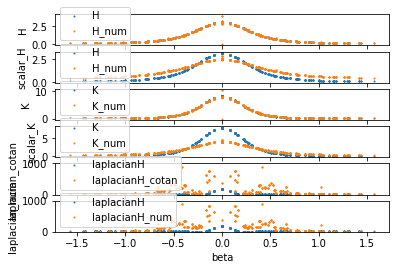

In [64]:
def inverseMassMatrix():
    M_inv = system.getLumpedMassMatrix()
    np.reciprocal(M_inv.data, out=M_inv.data)
    return M_inv
def rowwiseScaling(scaling, matrix):
    return matrix * scaling[:,None]

def rowwiseNorm(matrix):
    return np.sum(np.abs(matrix)**2, axis=-1)*(1./2)


system = dg.System(topo, coord, parameters)
M_inv =  1/system.getVertexDualArea()
H_num = rowwiseScaling(M_inv,system.getMeanCurvatureVector())
K_num = rowwiseScaling(M_inv,system.getGaussianCurvatureVector())
laplacianH_num = -rowwiseScaling(M_inv,system.getLaplacianMeanCurvatureVector())

scalarH = -M_inv  * (system.getCotanLaplacian() @ (M_inv * system.getMeanCurvature()))
laplacianH_cotan = rowwiseScaling(scalarH,system.getAngleWeightedNormal())

# print(S_num)
# print("laplacianH analytically is ", np.sum(
#     rowwiseNorm(laplacianH)))
# print("laplacianH numerically is ", np.sum(rowwiseNorm(laplacianH_num)))
# print("H analytically is ", np.sum(
#     rowwiseNorm(H)))
# print("H numerically is ", np.sum(rowwiseNorm(H_num)))
# print("K analytically is ", np.sum(
#     rowwiseNorm(K)))
# print("K numerically is ", np.sum(rowwiseNorm(K_num)))
# print("S analytically is ", np.sum(
#     rowwiseNorm(S)))
# print("S numerically is ", np.sum(rowwiseNorm(S_num)))
# polyVisualize()

size = 1
i = -1

fig, ax = plt.subplots(6,1)
ax_ = ax[0]
ax_.set_xlabel('beta')
ax_.set_ylabel('H')
ax_.scatter(parametricBeta, rowwiseNorm(H), s=size,label = "H")
ax_.scatter(parametricBeta, rowwiseNorm(H_num), s=size,label = "H_num")
ax_.legend()

ax_ = ax[1]
ax_.set_xlabel('beta')
ax_.set_ylabel('scalar_H')
ax_.scatter(parametricBeta, rowwiseNorm(H), s=size, label = "H")
ax_.scatter(parametricBeta, M_inv * system.getMeanCurvature(), s=size,label = "H_num")
ax_.legend()

ax_ = ax[2]
ax_.set_xlabel('beta')
ax_.set_ylabel('K')
ax_.scatter(parametricBeta, rowwiseNorm(K), s=size,label = "K")
ax_.scatter(parametricBeta, rowwiseNorm(K_num), s=size,label = "K_num")
ax_.legend()

ax_ = ax[3]
ax_.set_xlabel('beta')
ax_.set_ylabel('scalar_K')
ax_.scatter(parametricBeta, rowwiseNorm(K), s=size, label = "K")
ax_.scatter(parametricBeta, M_inv * system.getGaussianCurvature(), s=size,label = "K_num")
ax_.legend()

ax_ = ax[4]
ax_.set_xlabel('beta')
ax_.set_ylabel('laplacian_cotan')
# ax_.plot(parametricBeta, rowwiseNorm(laplacianH), 'o', label = "laplacianH")
ax_.scatter(parametricBeta, rowwiseNorm(laplacianH), s=size, label = "laplacianH")
ax_.scatter(parametricBeta, rowwiseNorm(laplacianH_cotan), s=size,label = "laplacianH_cotan")
ax_.set_ylim([0, 1000])
ax_.legend()

ax_ = ax[5]
ax_.set_xlabel('beta')
ax_.set_ylabel('laplacian_num')
# ax_.plot(parametricBeta, rowwiseNorm(laplacianH), 'o', label = "laplacianH")
ax_.scatter(parametricBeta, rowwiseNorm(laplacianH), s=size, label = "laplacianH")
ax_.scatter(parametricBeta, rowwiseNorm(laplacianH_num), s=size,label = "laplacianH_num")
ax_.set_ylim([0, 1000])
ax_.legend()



plt.show()


Analytical solution of integrated value

In [10]:
def normalVectorDotCoordinate_sym(geocentricBeta):
    l = sphericalRadius_sym(geocentricBeta)
    coordinate = sp.Matrix(
        [[l * sp.cos(geocentricBeta), l * sp.sin(geocentricBeta)]])
    normalVector = normalVector_sym_2(geocentricBeta)
    return coordinate.dot(normalVector)


def wikiExplicitArea():
    return 2 * np.pi * a**2 + np.pi * c**2 / e * math.log((1+e)/(1-e))


def areaElement_sym(geocentricBeta):
    l = sphericalRadius_sym(geocentricBeta)
    dldbeta = sp.diff(l, geocentricBeta)
    return 2 * sp.pi * l * sp.cos(geocentricBeta) * sp.sqrt(l**2 + dldbeta**2)


def wikiExplicitVolume():
    return 4 / 3 * np.pi * a**2 * c


def volumeElement_sym(parametricBeta):
    return normalVectorDotCoordinate_sym(parametricBeta) / 3 * areaElement_sym(geocentricBeta)


geocentricBeta = sp.symbols('geocentricBeta')

area = sp.Integral(areaElement_sym(geocentricBeta),
                   (geocentricBeta, -sp.pi/2, sp.pi/2)).evalf()
print("analytical area: ", area)
area = wikiExplicitArea()
print("analytical area: ", area)

volume = sp.Integral(volumeElement_sym(geocentricBeta),
                     (geocentricBeta, -sp.pi/2, sp.pi/2)).evalf()
print("analytical volume: ", volume)
volume = wikiExplicitVolume()
print("analytical volume: ", volume)

totalMeanCurvature = sp.Integral(meanCurvature_sym(geocentricToParametricLatitude_sym(
    geocentricBeta)) * areaElement_sym(geocentricBeta), (geocentricBeta, -sp.pi/2, sp.pi/2)).evalf()
print("analytical total mean curvature: ", totalMeanCurvature)
totalMeanCurvatureSquared = sp.Integral(meanCurvature_sym(geocentricToParametricLatitude_sym(
    geocentricBeta))**2 * areaElement_sym(geocentricBeta), (geocentricBeta, -sp.pi/2, sp.pi/2)).evalf()
print("analytical total mean curvature squared: ", totalMeanCurvatureSquared)

totalGaussianCurvature = sp.Integral(gaussianCurvature_sym(geocentricToParametricLatitude_sym(
    geocentricBeta)) * areaElement_sym(geocentricBeta), (geocentricBeta, -sp.pi/2, sp.pi/2)).evalf()
print("analytical total gaussian curvature: ", totalGaussianCurvature)


analytical area:  8.67188270334505
analytical area:  8.671882703345052
analytical volume:  2.09439510239320
analytical volume:  2.0943951023931953
analytical total mean curvature:  10.7392176639419
analytical total mean curvature squared:  16.9023119660317
analytical total gaussian curvature:  12.5663706143592


numerical solution of integrated values

In [149]:
print("numerical area: ", system.surfaceArea)
print("numerical volume: ", system.volume)
print("analytical total mean curvature: ", np.sum(
    system.getLumpedMassMatrix() * system.getMeanCurvature()))
print("analytical total mean curvature squared: ", np.sum(
    system.getLumpedMassMatrix() * system.getMeanCurvature()**2))
print("analytical total gaussian curvature squared: ", np.sum(
    system.getLumpedMassMatrix() * system.getGaussianCurvature()))


numerical area:  8.630594978422554
numerical area:  2.076370408546518
analytical total mean curvature:  10.722161742668913
analytical total mean curvature squared:  16.871100849664902
analytical total gaussian curvature squared:  12.566370614359037
